# Pedestrian accidents 2023 - Decision Tree

## Dictionary

In [1]:
from dictionary import dictionary 
ACCIDENT_TYPES_KEY = 'p6'

## Imports and functions

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from datetime import datetime

# Function to treat missing values
def treatMissingValues(df, column, strategy='mean', fill_value=None):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame.")
    
    df_copy = df.copy()

    if column not in df_copy.columns:
        print(f"Column '{column}' not found in the DataFrame.")
        return df_copy
    
    col_dtype = df_copy[column].dtype
    
    if df_copy[column].isnull().sum() == 0:
        print(f"No missing values found in column '{column}'.")
        return df_copy
    
    if strategy == 'mean' and col_dtype in ['int64', 'float64']:
        mean_value = df_copy[column].mean()
        fill_value = round(mean_value)
    elif strategy == 'mode':
        fill_value = df_copy[column].mode()[0]
    elif strategy == 'median' and col_dtype in ['int64', 'float64']:
        fill_value = df_copy[column].median()
    elif strategy == 'ffill':
        df_copy[column].fillna(method='ffill', inplace=True)
        return df_copy
    elif strategy == 'bfill':
        df_copy[column].fillna(method='bfill', inplace=True)
        return df_copy
    elif strategy == 'custom':
        if fill_value is None:
            print("Error: 'fill_value' must be provided when 'strategy' is 'custom'.")
            return df_copy
    else:
        print("Invalid strategy.")
        return df_copy
    
    df_copy[column].fillna(fill_value, inplace=True)
    print(f"Filled missing values in column '{column}' with {strategy}: {fill_value}")
    
    return df_copy

# Calculate age
current_year = datetime.now().year

def calculate_age(birthday_year):
    try:
        year = int(birthday_year)
        current_year_last_two_digit = current_year % 100
        # Convert to full years
        full_year = 1900 + year if year > current_year_last_two_digit else 2000 + year
        return current_year - full_year
    except (TypeError, ValueError):
        return None
    

def assign_age_group(age):
    if age <= 15:
        return 0
    elif age <= 26:
        return 1
    elif age <= 50:
        return 2
    elif age <= 65:
        return 3
    elif age <= 80:
        return 4
    else:
        return 5  
    
def translate_and_print_example(models, example):
    example_name = example.name
    translated_keys = [dictionary.get(key, {}).get('label', key) for key in example.index]
    translated_values = [dictionary.get(key, {}).get('items', {}).get(str(int(value)), value) for key, value in example.items()]
    prediction = models['p33g'].predict([example]) 
    result = prediction[0]
    label = dictionary.get('p33g', {}).get('items', {}).get(str(result), result)

    print(f"{example_name}: >>")
    for key, value, translated_value in zip(translated_keys, example, translated_values):
        print(f"{key}: {translated_value if translated_value != value else value}")
    print("Prediction:", label, " <<")    

## Data preprocessing
### Import accidents dataset

In [3]:
# Load accidents from CSV file
raw_data_accidents = pd.read_csv('output/Inehody_raw.csv',delimiter=';')

# Selected columns that may affect result
data_accidents_column_names = ['p1', 'p5a', 'p6', 'p7', 'p8', 'p10','p11','p11a', 'p12','p15', 'p16', 'p17','p18', 'p19', 'p20', 'p21', 'p22', 'p23','p28', 'p36' ]
print(f"Imported {len(data_accidents_column_names)} columns:",[dictionary.get(str(column), str(column)).get('label', str(column)) for column in data_accidents_column_names])
data_accidents = raw_data_accidents.loc[:, data_accidents_column_names]

# Make sure they are unique
unique_p1_accidents = data_accidents['p1'].unique()
data_accidents = pd.merge(data_accidents, pd.DataFrame({'p1': unique_p1_accidents}), on='p1', how='inner')

# Check is unique (same rows)
assert unique_p1_accidents.shape[0] == data_accidents.shape[0], "Dataset is not unique."

print(data_accidents)
print(data_accidents.shape)

Imported 20 columns: ['id', 'Lokalita nehody', 'Druh nehody', 'Druh srazky jedouciho vozidel', 'Druh pevne prekazky', 'Zavineni nehody', 'Pritomnost alkoholu u vinika', 'Pritomnost drog u vinika', 'Hlavni priciny nehody', 'Typ povrchu silnice', 'Stav povrchu vozovky v dobe nehody', 'Stav komunikace', 'Povetrnostni podminky v dobe nehody', 'Viditelnosti', 'Rozhledove podminky', 'Deleni komunikace', 'Situovani nehody na komunikaci', 'Rizeni provozu v dobe nehody', 'Smerove pomery', 'Druh pozemni komunikace']
                 p1  p5a  p6  p7  p8  p10  p11  p11a  p12  p15  p16  p17  p18  \
0       10623000002    2   5   0   0    4    0   8.0  100    2    2    1    1   
1       60223000039    1   3   0   3    1    0   8.0  508    1    1    1    1   
2          23000455    1   1   4   0    1    2   8.0  504    2    3    1    1   
3       70623000019    2   5   0   0    4    0   8.0  100    2    3    1    1   
4      161723000024    2   5   0   0    4    0   8.0  100    2    3    1    1   
..

### Import pedestrian dataset

In [4]:
# Load pedestrians from CSV file
raw_data_pedestrians = pd.read_csv('output/Ichodci_raw.csv',delimiter=';')

# Choose columns that may affect result
data_pedestrians_column_names = ['p1','p29a','p29b','p30a','p30b', 'p31', 'p33c', 'p33d', 'p33f', 'p33g' ]
print(f"Imported {len(data_pedestrians_column_names)} columns:",[dictionary.get(column, {}).get('label') or column for column in data_pedestrians_column_names])
data_pedestrians = raw_data_pedestrians.loc[:, data_pedestrians_column_names]

print(data_pedestrians)

Imported 10 columns: ['id', 'Reflexni prvky u chodce', 'Chodec na osobnim prepravniku', 'Pritomnost alkoholu (Chodec)', 'Druhy drogy u chodce', 'Chovani chodce', 'Pohlavi chodce', 'Rok narozeni chodce (posledni dvojcisli)', 'Poskytnuti prvni pomoci', 'Nasledky pro chodce']
                p1  p29a  p29b  p30a  p30b  p31  p33c p33d  p33f  p33g
0      70623000032   2.0   2.0   0.0   8.0    1     2   45     6     3
1      70623000013   2.0   2.0   2.0   8.0    2     2   77     2     3
2      70323000011   2.0   2.0   2.0   0.0    1     4   11     3     3
3         23003157   2.0   2.0   2.0   8.0    1     1   43     1     4
4     180523000030   2.0   2.0   2.0   0.0    1     1   17     5     3
...            ...   ...   ...   ...   ...  ...   ...  ...   ...   ...
3286      23013936   2.0   2.0   2.0   0.0    0     2   05     1     4
3287   70123000784   2.0   2.0   2.0   0.0    1     1   29     2     3
3288   20323000286   2.0   2.0   0.0   0.0    0     1   82     5     3
3289   203230002

### Join dataset by ID

In [5]:
# Right join pedestrian table, we only interest in accidents on pedestrian
data = pd.merge(data_accidents, data_pedestrians, on='p1', how='right')
total_missing_values = data.isnull().sum().sum()

print("Merged data:", data)

Merged data:                 p1  p5a  p6  p7  p8  p10  p11  p11a  p12  p15  ...  p36  p29a  \
0      70623000032    1   4   0   0    1    0   0.0  412    2  ...    1   2.0   
1      70623000013    1   4   0   0    3    2   0.0  100    2  ...    3   2.0   
2      70323000011    1   4   0   0    1    0   8.0  506    2  ...    1   2.0   
3         23003157    1   4   0   0    1    0   8.0  412    1  ...    6   2.0   
4     180523000030    1   4   0   0    1    2   8.0  412    2  ...    6   2.0   
...            ...  ...  ..  ..  ..  ...  ...   ...  ...  ...  ...  ...   ...   
3286      23013936    1   4   0   0    1    2   8.0  412    2  ...    6   2.0   
3287   70123000784    1   4   0   0    1    2   0.0  508    2  ...    6   2.0   
3288   20323000286    1   4   0   0    1    2   8.0  508    1  ...    2   2.0   
3289   20323000286    1   4   0   0    1    2   8.0  508    1  ...    2   2.0   
3290  170623001589    1   4   0   0    3    2   8.0  100    2  ...    6   2.0   

      p29b  p3

### Split accidents dataset

In [6]:
X = data.drop(['p1', 'p33g'], axis=1)
y = data.loc[:, ['p33g']]

print(f"Columns:",[dictionary.get(str(column), str(column)).get('label', str(column)) for column in X])
print(f"Target:",[dictionary.get(str(column), str(column)).get('label', str(column)) for column in y])

# Splitting the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30/70
print(f"Training data: {len(X_train)} rows")
print(f"Testing data: {len(X_test)} rows")

print(X_train)

Columns: ['Lokalita nehody', 'Druh nehody', 'Druh srazky jedouciho vozidel', 'Druh pevne prekazky', 'Zavineni nehody', 'Pritomnost alkoholu u vinika', 'Pritomnost drog u vinika', 'Hlavni priciny nehody', 'Typ povrchu silnice', 'Stav povrchu vozovky v dobe nehody', 'Stav komunikace', 'Viditelnosti', 'Rozhledove podminky', 'Deleni komunikace', 'Situovani nehody na komunikaci', 'Rizeni provozu v dobe nehody', 'Smerove pomery', 'Druh pozemni komunikace', 'Reflexni prvky u chodce', 'Chodec na osobnim prepravniku', 'Pritomnost alkoholu (Chodec)', 'Druhy drogy u chodce', 'Chovani chodce', 'Pohlavi chodce', 'Rok narozeni chodce (posledni dvojcisli)', 'Poskytnuti prvni pomoci']
Target: ['Nasledky pro chodce', 'Povetrnostni podminky v dobe nehody']
Training data: 2303 rows
Testing data: 988 rows
      p5a  p6  p7  p8  p10  p11  p11a  p12  p15  p16  ...  p28  p36  p29a  \
59      1   4   0   0    1    2   0.0  506    2    3  ...    1    6   2.0   
1037    1   4   0   0    1    2   0.0  504    1  

### Preprocessing training dataset

In [7]:
AGE_COLUMN = 'p33d'    
# Apply the calculate function
X_train[AGE_COLUMN] = X_train[AGE_COLUMN].apply(calculate_age)

# Apply treatement mean for age
X_train = treatMissingValues(df=X_train, column=AGE_COLUMN, strategy='mean')

# Convert age into group
X_train['age_group'] = [assign_age_group(age) for age in X_train[AGE_COLUMN]]

# Check for missing values in each column
for column in X_train.columns:
    missing_values_count = X_train[column].isnull().sum()
    if missing_values_count > 0:
        default_value = dictionary.get(column,{}).get('default')
        if default_value:
            X_train = treatMissingValues(df=X_train, column=column, strategy='custom', fill_value=default_value)
        else:    
            print(f"Column '{column}' has {missing_values_count} missing value(s). There is no default value defined for '{column}'. Please provide treatment manually.")


# Drop after age assignment
X_train.drop(columns=[AGE_COLUMN], inplace=True)

# check missing values treatement
missing_values_per_column = X_train.isnull().any()
assert not missing_values_per_column.any(), "Columns with missing values: {missing_values_per_column[missing_values_per_column]}"

print(X_train)

Filled missing values in column 'p33d' with mean: 48
Filled missing values in column 'p11a' with custom: 8
Filled missing values in column 'p29a' with custom: 2
Filled missing values in column 'p29b' with custom: 2
Filled missing values in column 'p30a' with custom: 0
Filled missing values in column 'p30b' with custom: 8
      p5a  p6  p7  p8  p10  p11 p11a  p12  p15  p16  ...  p28  p36  p29a  \
59      1   4   0   0    1    2  0.0  506    2    3  ...    1    6   2.0   
1037    1   4   0   0    1    2  0.0  504    1    1  ...    4    6   2.0   
2980    1   4   0   0    1    2  0.0  504    2    3  ...    1    6   1.0   
1232    1   4   0   0    3    2  8.0  100    2    1  ...    1    6   2.0   
3289    1   4   0   0    1    2  8.0  508    1    1  ...    4    2   2.0   
...   ...  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
1095    2   4   0   0    1    4  8.0  502    2    1  ...    1    3   2.0   
1130    1   4   0   0    3    2  8.0  100    2    1  ...    3    6   

### Preprocessing testing dataset

In [8]:
# Apply the calculate function
AGE_COLUMN = 'p33d'
X_test[AGE_COLUMN] = X_test[AGE_COLUMN].apply(calculate_age)

# Apply treatement mean for age
X_test = treatMissingValues(df=X_test, column=AGE_COLUMN, strategy='mean')

# Convert age into group
X_test['age_group'] = [assign_age_group(age) for age in X_test[AGE_COLUMN]]

# Check for missing values in each column
for column in X_test.columns:
    missing_values_count = X_test[column].isnull().sum()
    if missing_values_count > 0:
        default_value = dictionary.get(column,{}).get('default')
        if default_value:
            X_test = treatMissingValues(df=X_test, column=column, strategy='custom', fill_value=default_value)
        else:    
            print(f"Column '{column}' has {missing_values_count} missing value(s). There is no default value defined for '{column}'. Please provide treatment manually.")

# Drop after age assignment
X_test.drop(columns=[AGE_COLUMN], inplace=True)

# check missing values treatement
missing_values_per_column = X_test.isnull().any()
assert not missing_values_per_column.any(), "Columns with missing values: {missing_values_per_column[missing_values_per_column]}"
print(X_test)

Filled missing values in column 'p33d' with mean: 47
Filled missing values in column 'p11a' with custom: 8
Filled missing values in column 'p29a' with custom: 2
Filled missing values in column 'p29b' with custom: 2
Filled missing values in column 'p30a' with custom: 0
Filled missing values in column 'p30b' with custom: 8
      p5a  p6  p7  p8  p10  p11 p11a  p12  p15  p16  ...  p28  p36  p29a  \
3097    1   4   0   0    3    0  0.0  100    2    3  ...    1    1   2.0   
3160    1   4   0   0    1    2  8.0  508    1    0  ...    1    6   2.0   
1927    1   4   0   0    3    2  0.0  100    2    1  ...    4    6   2.0   
2597    1   4   0   0    3    2  0.0  100    2    0  ...    1    3   2.0   
1760    1   4   0   0    1    0  0.0  511    2    1  ...    1    6   2.0   
...   ...  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
2858    1   4   0   0    1    2  0.0  504    2    1  ...    1    6   2.0   
1114    1   4   0   0    1    2  8.0  506    2    1  ...    1    2   

## Decitions Tree

In [9]:
# Model loop in case to run multiple targets
models = {}

for column in y.columns:
    # run treatment if there are
    if y_train[column].isnull().sum() > 0:
        default_value = dictionary.get(column,{}).get('default')
        y_train = treatMissingValues(df=y_train, column=column, strategy='custom', fill_value=default_value)
    clf = DecisionTreeClassifier()
    print( y_train[column])
    clf.fit(X_train, y_train[column])
    models[column] = clf

# Evaluate the Model
accuracies = {}
for column in y.columns:
    y_pred = models[column].predict(X_test)
    accuracies[column] = accuracy_score(y_test[column], y_pred)
    print(f"Accuracy for {dictionary.get(column,{}).get('label')}: {accuracies[column]}")

    print(f"\nConfusion Matrix for {dictionary.get(column,{}).get('label')}:\n")
    print(confusion_matrix(y_test[column], y_pred))

    print(f"\nClassification Report for {dictionary.get(column,{}).get('label')}:\n")
    print(classification_report(y_test[column], y_pred))

59      4
1037    3
2980    3
1232    3
3289    2
       ..
1095    4
1130    3
1294    3
860     3
3174    3
Name: p33g, Length: 2303, dtype: int64
59      1
1037    1
2980    5
1232    1
3289    1
       ..
1095    1
1130    1
1294    1
860     1
3174    4
Name: p18, Length: 2303, dtype: int64
Accuracy for Nasledky pro chodce: 0.7348178137651822

Confusion Matrix for Nasledky pro chodce:

[[  6   4  11   2]
 [  5  17  70   4]
 [ 12  92 594  39]
 [  3   2  18 109]]

Classification Report for Nasledky pro chodce:

              precision    recall  f1-score   support

           1       0.23      0.26      0.24        23
           2       0.15      0.18      0.16        96
           3       0.86      0.81      0.83       737
           4       0.71      0.83      0.76       132

    accuracy                           0.73       988
   macro avg       0.49      0.52      0.50       988
weighted avg       0.75      0.73      0.74       988

Accuracy for Povetrnostni podminky v dobe neh

## Display Decision Tree

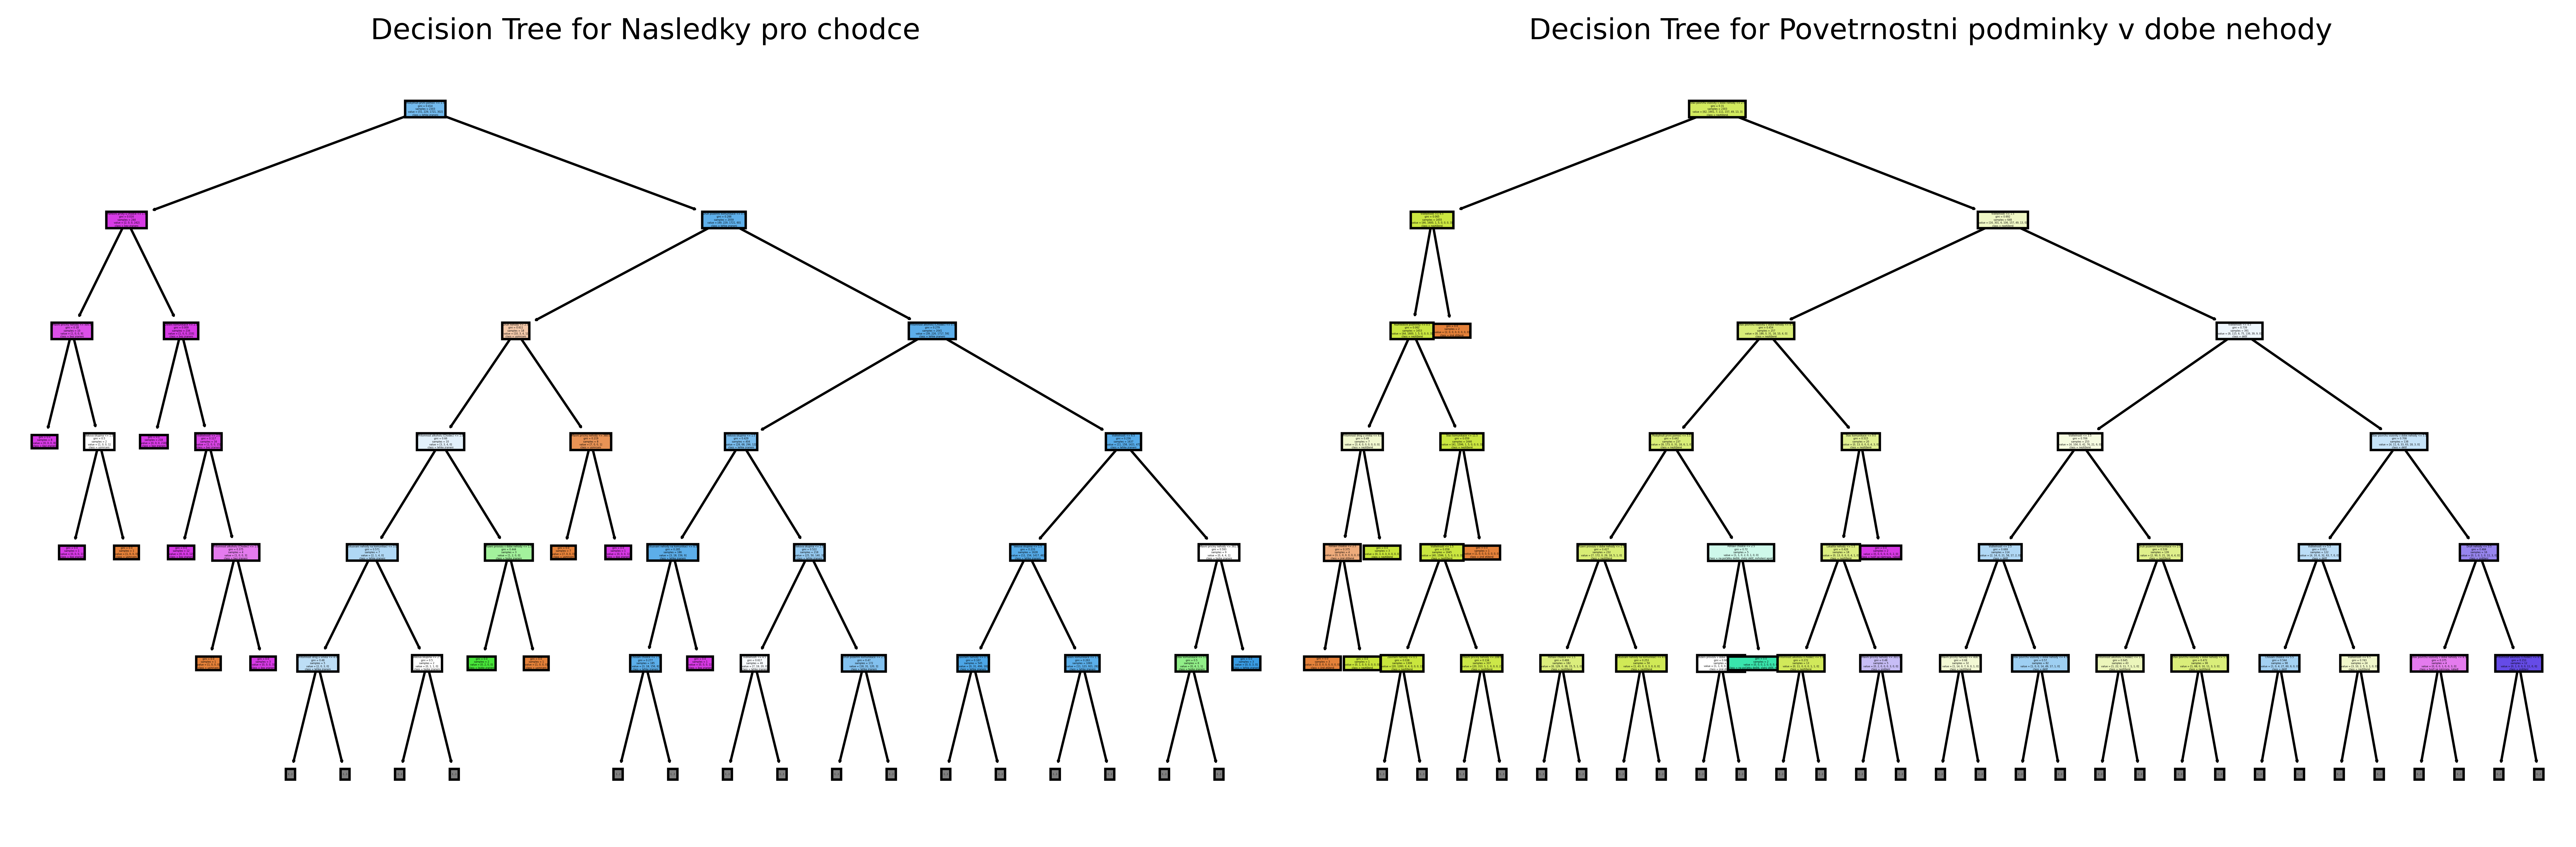

In [10]:

plt.figure(figsize=(15, 5), dpi=600)
for i, column in enumerate(y.columns, start=1):
    plt.subplot(1, len(y.columns), i)
    features = [dictionary.get(name, {}).get('label', name) for name in models[column].feature_names_in_]
    class_labels = [dictionary.get(column, {}).get('items',{}).get(str(label),label) for label in models[column].classes_]
    plot_tree(models[column], filled=True, feature_names=features, class_names=class_labels, max_depth=5)
    plt.title(f"Decision Tree for {dictionary.get(column,{}).get('label')}")
plt.tight_layout()
plt.show()

## Metaparameter tuning

In [11]:
from sklearn.model_selection import GridSearchCV

# max dephth columns + 1
param_grid = {
    'max_depth': range(1, X.shape[1] + 1),
    'min_samples_split': range(2, 15),
    'min_samples_leaf': range(1, 8)
}

best_models = {}

for column in y.columns:
    clf = DecisionTreeClassifier()
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train[column])
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train[column])
    best_models[column] = best_model

print(best_models)

best_accuracies = {}
for column in y.columns:
    y_pred = best_models[column].predict(X_test)
    best_accuracies[column] = accuracy_score(y_test[column], y_pred)
    print(f"Best accuracy for {dictionary.get(column,{}).get('label')}: {best_accuracies[column]}")


/Users/luckykiet/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


## Manually test models

In [ ]:
# Test
translate_and_print_example(models=models, example=X_test.iloc[160])
translate_and_print_example(models=models, example=X_test.iloc[161])
translate_and_print_example(models=models, example=X_test.iloc[300])
translate_and_print_example(models=models, example=X_test.iloc[600])